# Modelling Exercises

## Exercise 1: Model Selection

Today we are working with the `California Housing dataset`, which you are already familiar with, as we previously used it while exploring resampling method.
This dataset is based on the 1990 U.S. Census and includes features describing California districts. 

1) Familiarize yourself with the data
    - What kind of features are in the dataset? What is the target?
2) Baseline model 
    - Create a baseline linear regression model using **all** features and evaluate the model through 5-fold cross validation, using R² as the performance metric
    - Print the individual and average R²
3) Apply a forward stepwise selection to find a simpler suitable model.
    - Split the data into 80% training data and 20% testing data (print the shape to confirm it was sucessful)
    - Perform a forward stepwise selection with a linear regression model, 5-fold CV, R² score, and `parsimonious` feature selection (refer to [documentation](https://rasbt.github.io/mlxtend/api_subpackages/mlxtend.feature_selection/) for further information)
    - Print the best CV R² as well as the chosen features
4) Evaluate the model on the test set

In [3]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from mlxtend.feature_selection import SequentialFeatureSelector

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


# 1) Load the California housing dataset
data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target


# 2) Create baseline model 
model = LinearRegression()
scores = cross_val_score(model, X, y, cv=5, scoring='r2')

# Print the results
print("R² scores from each fold:", scores)
print("Average R² score:", np.mean(scores))


# 3) Apply a forward stepwise selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

# Forward Sequential Feature Selector
sfs_forward = SequentialFeatureSelector(
    estimator=LinearRegression(),
    k_features="parsimonious",
    forward=True,
    floating=False,
    scoring='r2',
    cv=5,
    verbose=0)

sfs_forward.fit(X_train, y_train)

print(f">> Forward SFS:")
print(f"   Best CV R²      : {sfs_forward.k_score_:.3f}")
print(f"   Optimal # feats : {len(sfs_forward.k_feature_idx_)}")
print(f"   Feature names   : {sfs_forward.k_feature_names_}")


# 4) Evaluate the model
selected_features = list(sfs_forward.k_feature_names_)

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train and evaluate
model.fit(X_train_selected, y_train)
test_r2 = model.score(X_test_selected, y_test)
print(f"Test R² for the sfs model: {test_r2:.4f}")

R² scores from each fold: [0.54866323 0.46820691 0.55078434 0.53698703 0.66051406]
Average R² score: 0.5530311140279571
(16512, 8) (4128, 8)
(16512,) (4128,)
>> Forward SFS:
   Best CV R²      : 0.612
   Optimal # feats : 7
   Feature names   : ('MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude')
Test R² for the sfs model: 0.5757


## Exercise 2: LASSO

Please implement a Lasso regression model similar to the Ridge model in the [Regularization](2_Regularization) section.

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm 

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

# Data related processing
hitters = sm.datasets.get_rdataset("Hitters", "ISLR").data
hitters_subset = hitters[["Salary", "AtBat", "Runs","RBI", "CHits", "CAtBat", "CRuns", "CWalks", "Assists", "Hits", "HmRun", "Years", "Errors", "Walks"]].copy()
hitters_subset = hitters_subset.drop(columns=["CRuns", "CAtBat"]) # Remove highly correlated features (see previous session)
hitters_subset.dropna(inplace=True) # drop rows containing missing data

y = hitters_subset["Salary"]
X = hitters_subset.drop(columns=["Salary"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler() # Scale predictors to mean=0 and std=1
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Lasso 
lambda_range = np.linspace(0.001, 20, 100) 

# Get the optimal lambda
lasso_cv = LassoCV(alphas=lambda_range)
lasso_cv.fit(X_train_scaled, y_train) 

print(f"Optimal alpha: {lasso_cv.alpha_}\n")

# Get training R²
train_score_ridge= lasso_cv.score(X_train_scaled, y_train)
print(f"Training R²: {train_score_ridge}\n")

# Put the coefficients into a nicely formatted df for visualization
coef_table = pd.DataFrame({
    'Predictor': X_train.columns,
    'Beta': lasso_cv.coef_
})

coef_table = coef_table.reindex(coef_table['Beta'].abs().sort_values(ascending=False).index)
print(coef_table, "\n")


test_score_ridge= lasso_cv.score(X_test_scaled, y_test)
print(f"Test R²: {test_score_ridge}")

Optimal alpha: 20.0

Training R²: 0.47908195299121104

   Predictor        Beta
3      CHits  177.984173
6       Hits  101.982447
7      HmRun   52.177420
10     Walks   41.664953
2        RBI    0.000000
0      AtBat    0.000000
1       Runs    0.000000
5    Assists   -0.000000
4     CWalks    0.000000
8      Years    0.000000
9     Errors   -0.000000 

Test R²: 0.31479649243077035


## Exercise 3: GAMs (1)

Objective: Understand how the number of basis functions (df) and the polynomial degree (degree) affect the flexibility of a spline and the resulting fit in a Generalized Additive Model.

1. Use the diabetes dataset and focus on the relationship between `bmi` and `target`.
2. We want to test different combinations of parameters. For the dfs, please use 4, 6, 12. For the degree, please use 2 and 3 (quadratic and cubic).
3. Fit the GAMs for each parameter combination. The resulting models will be plotted automatically for visual comparison.

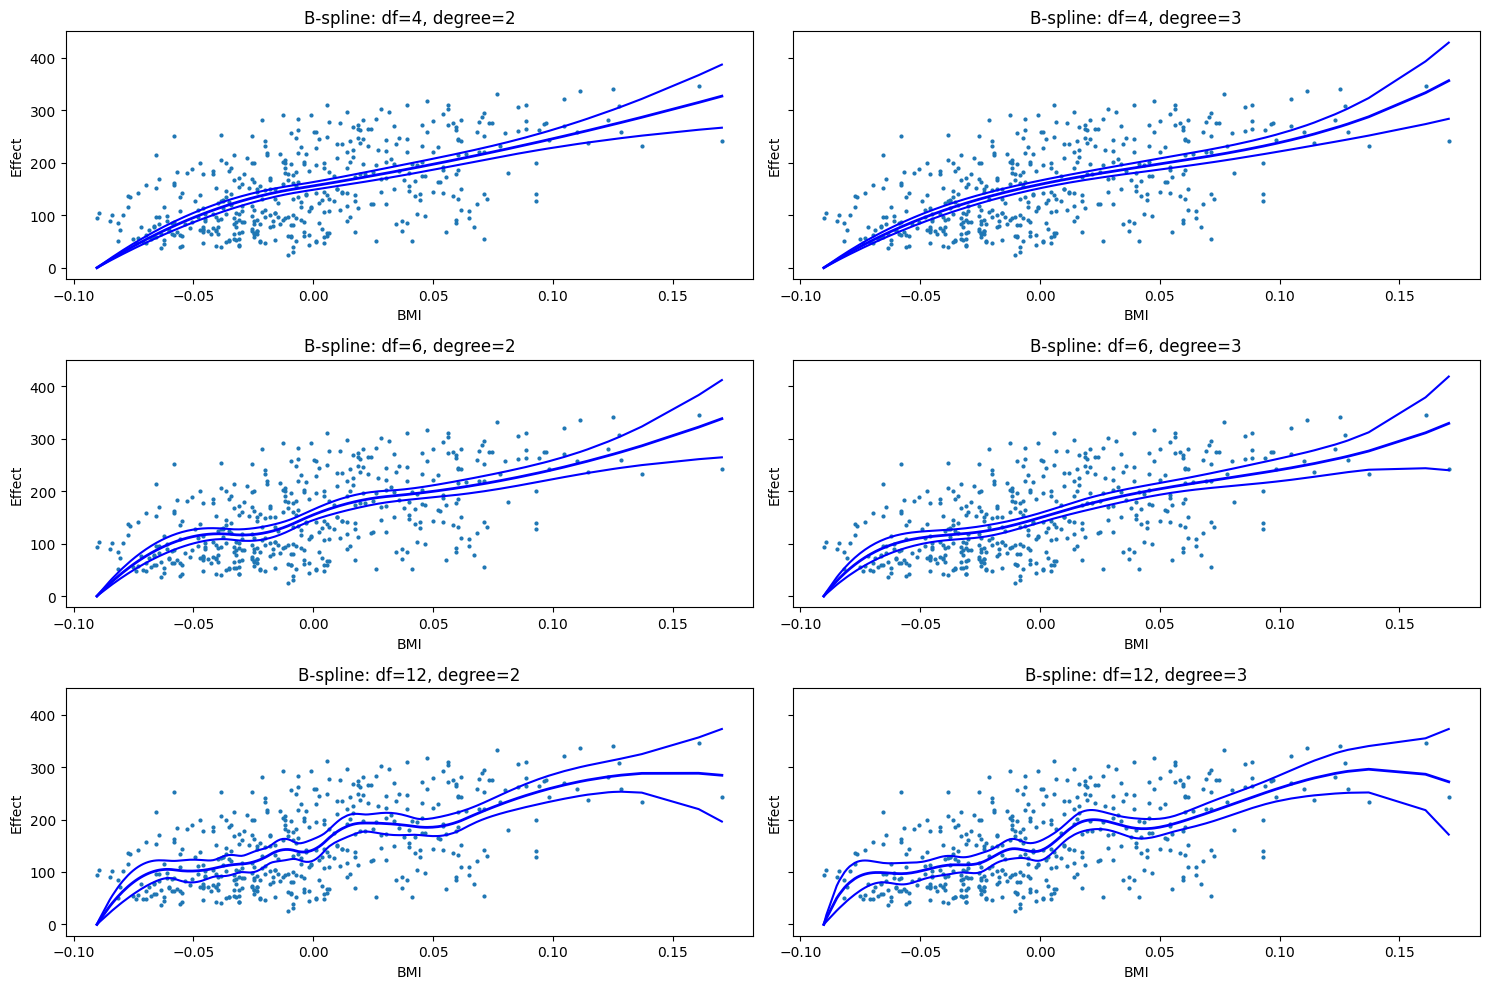

In [5]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from statsmodels.gam.api import GLMGam, BSplines

# 1. Get bmi as x and the target as y
data = load_diabetes(as_frame=True)
x = data.data[['bmi']]
y = data.target

# 2. Define possible parameters
df_values = [4, 6, 12]
degree_values = [2, 3]

# 3. PLot partial effect for each combination of df and degree
fig, axes = plt.subplots(len(df_values), len(degree_values), figsize=(15, 10), sharey=True)

for i, df_val in enumerate(df_values):
    for j, deg_val in enumerate(degree_values):
        bs = BSplines(x, df=df_val, degree=deg_val)
        gam = GLMGam(y, smoother=bs)
        res = gam.fit()

        res.plot_partial(0, cpr=True, ax=axes[i, j])
        axes[i, j].set_title(f'B-spline: df={df_val}, degree={deg_val}')
        axes[i, j].set_xlabel('BMI')
        axes[i, j].set_ylabel('Effect')

plt.tight_layout()
plt.show()

## Exercise 4: GAMs (2)

We now use the [wage](https://islp.readthedocs.io/en/latest/datasets/Wage.html) dataset, which contains income information for a group of workers, along with demographic and employment-related features such as age, education, marital status, and job class.

1) Explore the dataset
    - Which variables are numeric?
    - Which ones are categorical?

2) Fit a GAM predicting `wage` from `age`, `year`, `education`, `jobclass`, and `maritl`

Note: For categorical features we use a one-hot encoding with `pd.get_dummies()`

In [6]:
import pandas as pd
from ISLP import load_data
from statsmodels.gam.api import GLMGam, BSplines

# Load data
Wage = load_data('Wage')

# Continuous features
spline_features = ['age', 'year']
X_spline = Wage[spline_features]

# Categorical features — one-hot encode
categoricals = ['education', 'jobclass', 'maritl']
X_cat = pd.get_dummies(Wage[categoricals], drop_first=True)

# Outcome
y = Wage['wage']

# Create BSpline basis
bs = BSplines(X_spline, df=[6]*len(spline_features), degree=[3]*len(spline_features))

# Fit GAM
gam = GLMGam(y, exog=X_cat, smoother=bs)
res = gam.fit()

print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   wage   No. Observations:                 3000
Model:                         GLMGam   Df Residuals:                     2981
Model Family:                Gaussian   Df Model:                        18.00
Link Function:               Identity   Scale:                          1230.5
Method:                         PIRLS   Log-Likelihood:                -14920.
Date:                Wed, 14 May 2025   Deviance:                   3.6680e+06
Time:                        16:18:35   Pearson chi2:                 3.67e+06
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3436
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
education_2. HS 

## Exercise 5: KNN

You will implement a K-Nearest Neighbours (KNN) classifier to predict whether a patient is likely to have malignant or benign breast cancer based on several features. The data is already loaded for you, but please have a look a the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) to quickly refresh you memory about the dataset.

In [7]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Load the data
data = load_breast_cancer()
X, y = data.data, data.target

# Create a DataFrame for easier inspection and manipulation
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


Please implement the following:

1. Subset the dataframe to use `mean area`, `mean radius`, and `mean smoothness` as features (X), and `target` as the target (y)
2. Scale the predictors to mean 0 and variance 1
3. Split the data into a training and a testing set (70/30)
4. Train a kNN classifier with $k=5$
5. Evaluate the performance for the testing set. Please use the `accuracy_score()` as well as the `classification_report()` function. 

In [8]:
# Select features and target
X = df[['mean area', 'mean radius', 'mean smoothness']]
y = df['target']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Perform KNN classification
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Get predictions
y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8947368421052632

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.84      0.86        43
           1       0.90      0.93      0.92        71

    accuracy                           0.89       114
   macro avg       0.89      0.88      0.89       114
weighted avg       0.89      0.89      0.89       114



The classification model from the previous step has two main limitations:

1. It is trained and evaluated on a single data split
2. It uses a single $k$ even though we do not know if it is optimal

Please do the following:

1. Implement 5-fold cross validation
2. Train models for $k$ ranging from 1 to 200 and plot the mean accuracy over all folds

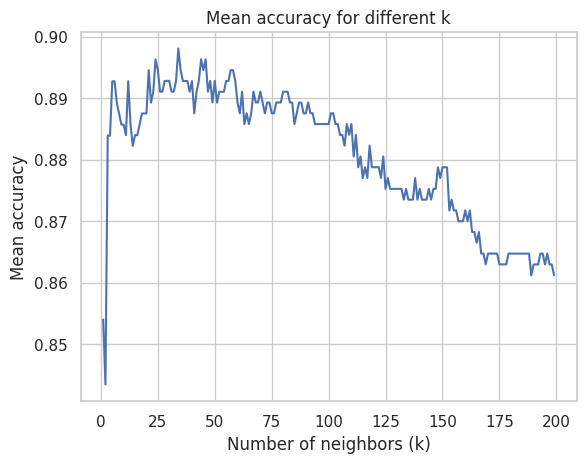

In [10]:
from sklearn.model_selection import cross_val_score
import seaborn as sns

k_values = range(1, 200)
mean_accuracies = []

# 5-fold cross-validation for different k values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_scaled, y, cv=5)
    mean_accuracies.append(scores.mean())

# Plot
fig, ax = plt.subplots()
sns.set_theme(style="whitegrid")
sns.lineplot(x=k_values, y=mean_accuracies, linestyle='-', ax=ax)
ax.set(xlabel='Number of neighbors (k)', ylabel='Mean accuracy', title='Mean accuracy for different k');

Discuss the results. How is the performance in general? Which $k$ would you chose?

## Exercise 6: LDA, QDA & Naïve Bayes

Once again, we will use the Iris dataset for classificationa analysis. Your task is to compare the performance of LDA, QDA, and Gaussian Naïve Bayes!

1. Load the `iris` dataset from `sklearn.datasets`. We will use only the first two features (sepal length and width)
2. `TODO:` Split the data into training and test sets ([use stratification!](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html))
3. `TODO:` Fit LDA, QDA, and Naïve Bayes classifiers to the training data and orint the classification report for all models on the test data
4. Plot the decision boundaries for both models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

# 1. Load data
iris = load_iris()
X = iris.data[:, :2]
y = iris.target
target_names = iris.target_names

# 2. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

In [2]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 3. TODO: Fit a LDA model and print the classification report
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

print(classification_report(y_test, lda.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.69      0.60      0.64        15
           2       0.65      0.73      0.69        15

    accuracy                           0.78        45
   macro avg       0.78      0.78      0.78        45
weighted avg       0.78      0.78      0.78        45



In [3]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# 3. TODO: Fit a QDA model and print the classification report
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

print(classification_report(y_test, qda.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.73      0.53      0.62        15
           2       0.63      0.80      0.71        15

    accuracy                           0.78        45
   macro avg       0.79      0.78      0.77        45
weighted avg       0.79      0.78      0.77        45



In [4]:
from sklearn.naive_bayes import GaussianNB

# 3. TODO: Fit a Gaussian Naive Bayes model and print the classification report
gnb = GaussianNB()
gnb.fit(X_train, y_train)

print(classification_report(y_test, gnb.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.71      0.67      0.69        15
           2       0.69      0.73      0.71        15

    accuracy                           0.80        45
   macro avg       0.80      0.80      0.80        45
weighted avg       0.80      0.80      0.80        45



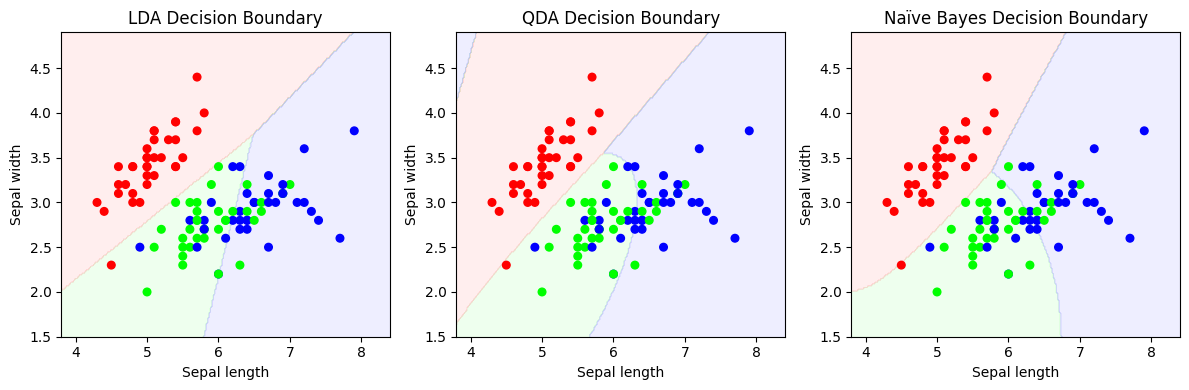

In [5]:
# 4. Plot the decision boundaries for all 3 classifiers

# Plotting function
def plot_decision_boundary(model, X, y, title, ax):
    h = .02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    ax.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.2)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=30)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title)
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')

# Create plots for all 3 classifiers
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_decision_boundary(lda, X_train, y_train, "LDA Decision Boundary", axes[0])
plot_decision_boundary(qda, X_train, y_train, "QDA Decision Boundary", axes[1])
plot_decision_boundary(gnb, X_train, y_train, "Naïve Bayes Decision Boundary", axes[2])
plt.tight_layout()

## Exercise 7: SVC

For the SVC exercise we will use the `fmri` dataset from `seaborn`, which contains measurements of brain activity (`signal`) in two brain regions (`frontal` and `parietal`) under two event types (`stim` vs. `cue`).

In [8]:
import seaborn as sns
df = sns.load_dataset("fmri")
df

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970
...,...,...,...,...,...
1059,s0,8,cue,frontal,0.018165
1060,s13,7,cue,frontal,-0.029130
1061,s12,7,cue,frontal,-0.004939
1062,s11,7,cue,frontal,-0.025367


We will try to answer a very simple research question:

> Can we distinguish between `cue` and `stim` events based on the fMRI signal in the `parietal` and `frontal` brain regions?

To do this, we need to turn the long‐format data into a classic “feature matrix” (one row = one sample, two columns = our two brain‐region signals) plus a corresponding label vector (cue/stim):

In [9]:
df_wide = df.pivot_table(
    index=["subject","timepoint","event"],
    columns="region",
    values="signal"
).reset_index()
df_wide.columns.name = None

X = df_wide[["frontal","parietal"]] 
y = df_wide["event"].map({"cue":0,"stim":1})

print("\nFeatures:")
print(X)
print("\nTarget:")
print(y)


Features:
      frontal  parietal
0    0.007766 -0.006899
1   -0.021452 -0.039327
2    0.016440  0.000300
3   -0.021054 -0.035735
4    0.024296  0.033220
..        ...       ...
527 -0.036739 -0.131641
528 -0.004900 -0.036362
529 -0.030099 -0.121574
530 -0.000643 -0.051040
531 -0.009959 -0.103513

[532 rows x 2 columns]

Target:
0      0
1      1
2      0
3      1
4      0
      ..
527    1
528    0
529    1
530    0
531    1
Name: event, Length: 532, dtype: int64


With the features and target in the correct form, please perform the following tasks:

1. Split the data into a train and test set
2. Scale the predictors to mean 0 and std 1
3. Fit a linear as well as a rbf SVC and **discuss the classification reports**

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# 1. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, stratify=y, random_state=42)

# 2. Scale the features after splitting (important to avoid data leakage)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

# 3. Fit the SVC models and compare the classification reports
clf_lin = SVC(kernel="linear", random_state=42)
clf_lin.fit(X_train_sc, y_train)
y_pred_lin = clf_lin.predict(X_test_sc)
print("Linear SVC\n", classification_report(y_test, y_pred_lin))

clf_rbf = SVC(kernel="rbf", random_state=42)
clf_rbf.fit(X_train_sc, y_train)
y_pred_rbf = clf_rbf.predict(X_test_sc)
print("RBF SVC\n", classification_report(y_test, y_pred_rbf))

Linear SVC
               precision    recall  f1-score   support

           0       0.55      0.99      0.71        80
           1       0.94      0.20      0.33        80

    accuracy                           0.59       160
   macro avg       0.75      0.59      0.52       160
weighted avg       0.75      0.59      0.52       160

RBF SVC
               precision    recall  f1-score   support

           0       0.67      0.85      0.75        80
           1       0.79      0.57      0.67        80

    accuracy                           0.71       160
   macro avg       0.73      0.71      0.71       160
weighted avg       0.73      0.71      0.71       160



After fitting both models, you can run the code chunk below to plot the decision boundary:

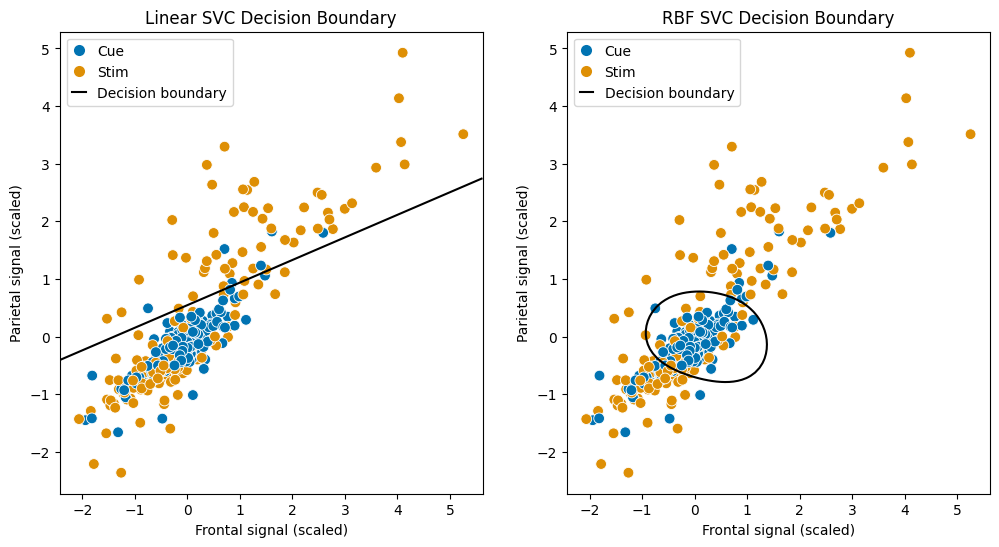

In [14]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_svc_decision_function(model, ax=None):
    """Plot the decision boundary for a trained 2D SVC model."""
    # Set up grid
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(*xlim, 100), np.linspace(*ylim, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]
    decision_values = model.decision_function(grid).reshape(xx.shape)
    ax.contour(xx, yy, decision_values, levels=[0], linestyles=['-'], colors='k')

# Plot
fig, ax = plt.subplots(1,2, figsize=(12, 6))

legend_elements = [
    Line2D([0], [0], marker='o', linestyle='None', markersize=8, label='Cue', markerfacecolor="#0173B2", markeredgecolor='None'),
    Line2D([0], [0], marker='o', linestyle='None', markersize=8, label='Stim', markerfacecolor="#DE8F05", markeredgecolor='None'),
    Line2D([0], [0], color='k', linestyle='-', label='Decision boundary')]

# Linear SVC
sns.scatterplot(x = X_train_sc[:, 0], y = X_train_sc[:, 1], hue = y_train.map({0:"cue",1:"stim"}), palette = ["#0173B2", "#DE8F05"], s = 60, ax = ax[0], legend=None)
ax[0].set(xlabel = "Frontal signal (scaled)", ylabel = "Parietal signal (scaled)", title  = "Linear SVC Decision Boundary")
plot_svc_decision_function(clf_lin, ax=ax[0])
ax[0].legend(handles=legend_elements, loc="upper left", handlelength=1)

# RBF SVC
sns.scatterplot(x = X_train_sc[:, 0], y = X_train_sc[:, 1], hue = y_train.map({0:"cue",1:"stim"}), palette = ["#0173B2", "#DE8F05"], s = 60, ax = ax[1], legend=None)
ax[1].set(xlabel = "Frontal signal (scaled)", ylabel = "Parietal signal (scaled)", title  = "RBF SVC Decision Boundary")
plot_svc_decision_function(clf_rbf, ax=ax[1])
ax[1].legend(handles=legend_elements, loc="upper left", handlelength=1);

Training a SVC on more complex datasets usually requires a parameter search to find the optimal hyperparameters. Please implement a grid search with the following options:

- Kernel:   rbf
- C:        np.logspace(-2,2,5)
- gamma:    np.logspace(-3,1,5)
- cv:       5-fold
- scoring:  accuracy

Print the optimal parameters and the corresponding accuracies for taining and testing.

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": np.logspace(-2,2,5),
    "gamma": np.logspace(-3,1,5)
}
grid = GridSearchCV(SVC(kernel="rbf"), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_sc, y_train)

print("Best params:", grid.best_params_)
print("CV accuracy:", grid.best_score_)
print("Test accuracy:", grid.score(X_test_sc, y_test))

Best params: {'C': np.float64(0.1), 'gamma': np.float64(10.0)}
CV accuracy: 0.7416576576576576
Test accuracy: 0.75
